In [1]:
import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation
class ReplayBuffer():
    def __init__(self, max_size, input_dims):
        self.mem_size = max_size
        self.mem_cntr = 0

        self.state_memory = np.zeros((self.mem_size, *input_dims), 
                                    dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims),
                                dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.int32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = 1 - int(done)
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        rewards = self.reward_memory[batch]
        actions = self.action_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
    model = Sequential()
    model.add(Flatten(input_shape=input_dims))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(n_actions))
    model.add(Activation('linear'))
    model.compile(Adam(lr=1e-3), metrics=['mae'], loss='mae')
    return model

class Agent():
    def __init__(self, lr, gamma, n_actions, epsilon, batch_size,
                input_dims, epsilon_dec=1e-2, epsilon_end=0.01,
                mem_size=1000000, fname='dqn_model.h5'):
        self.action_space = [i for i in range(n_actions)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = epsilon_dec
        self.eps_min = epsilon_end
        self.batch_size = batch_size
        self.model_file = fname
        self.memory = ReplayBuffer(mem_size, input_dims)
        self.q_eval = build_dqn(lr, n_actions, input_dims, 32, 32)
        #Teste do método construtor pra execução desse comando, para deixar o treinamento mais rápido
        #tf.compat.v1.disable_eager_execution()

    def store_transition(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, observation):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state = np.array([observation])
            actions = self.q_eval.predict(state)

            action = np.argmax(actions)

        return action

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        states, actions, rewards, states_, dones = self.memory.sample_buffer(self.batch_size)

        q_eval = self.q_eval.predict(states)
        q_next = self.q_eval.predict(states_)


        q_target = np.copy(q_eval)
        batch_index = np.arange(self.batch_size, dtype=np.int32)
        
        #dones = not(dones)
        #verificar depois!!!
        q_target[batch_index, actions] = rewards + self.gamma * np.max(q_next, axis=1) #* dones


        self.q_eval.train_on_batch(states, q_target)
        
    def decay_eps(self):
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > \
                self.eps_min else self.eps_min

    def save_model(self):
        self.q_eval.save(self.model_file)


    def load_model(self):
        self.q_eval = load_model(self.model_file)

In [12]:
#!pip install gym
import gym
env = gym.make('LunarLander-v2')
env.seed(42)
lr = 0.01
n_games = 1000

agent = Agent(gamma=0.95,
             epsilon=1.0,
             lr=lr,
             input_dims=env.observation_space.shape,
             n_actions=env.action_space.n,
             mem_size=10000,
             batch_size=128,
             epsilon_end=0.01,
             fname='model_dqn.h5' )
scores = []
eps_history = []
avg_scores = []

for i in range(n_games):
    done = False
    score = 0
    observation = env.reset()
    
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        
        #env.render()
        
        score += reward
        #print(done)
        agent.store_transition(observation, action, reward, observation_, done)
        observation = observation_
        agent.learn()
    agent.decay_eps()
    eps_history.append(agent.epsilon)
    scores.append(score)
    
    avg_score = np.mean(scores[-10:])
    avg_scores.append(avg_score)
    print('Episódio: ', i, ' Retorno %.2f' % score,
          'Retorno médio: %.2f' % avg_score, "epsilon: %.3f" % agent.epsilon)
agent.save_model()
env.close()

Episódio:  0  Retorno -444.94 Retorno médio: -444.94 epsilon: 0.990
Episódio:  1  Retorno -95.51 Retorno médio: -270.22 epsilon: 0.980
Episódio:  2  Retorno -253.22 Retorno médio: -264.56 epsilon: 0.970
Episódio:  3  Retorno -169.40 Retorno médio: -240.77 epsilon: 0.960
Episódio:  4  Retorno -95.66 Retorno médio: -211.74 epsilon: 0.950
Episódio:  5  Retorno -93.49 Retorno médio: -192.04 epsilon: 0.940
Episódio:  6  Retorno -135.22 Retorno médio: -183.92 epsilon: 0.930
Episódio:  7  Retorno -61.15 Retorno médio: -168.57 epsilon: 0.920
Episódio:  8  Retorno -430.27 Retorno médio: -197.65 epsilon: 0.910
Episódio:  9  Retorno -493.53 Retorno médio: -227.24 epsilon: 0.900
Episódio:  10  Retorno -136.71 Retorno médio: -196.42 epsilon: 0.890
Episódio:  11  Retorno -143.31 Retorno médio: -201.19 epsilon: 0.880
Episódio:  12  Retorno -129.86 Retorno médio: -188.86 epsilon: 0.870
Episódio:  13  Retorno -449.48 Retorno médio: -216.87 epsilon: 0.860
Episódio:  14  Retorno -140.79 Retorno médio: -2

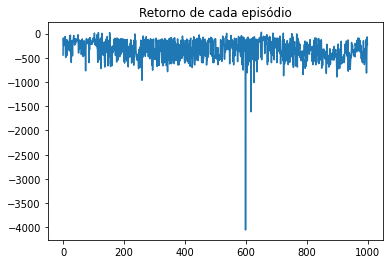

In [13]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.title("Retorno de cada episódio")
plt.show()

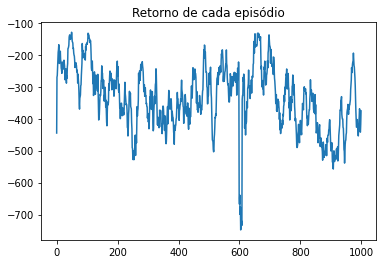

In [14]:
import matplotlib.pyplot as plt
plt.plot(avg_scores)
plt.title("Retorno de cada episódio")
plt.show()

In [17]:
#!pip install gym
import gym
env = gym.make('LunarLander-v2')
env.seed(42)
lr = 0.01
n_games = 1000

agent = Agent(gamma=0.95,
             epsilon=1.0,
             lr=lr,
             input_dims=env.observation_space.shape,
             n_actions=env.action_space.n,
             mem_size=10000,
             batch_size=128,
             epsilon_end=0.01,
             fname='model_dqn_32_32.h5' )
scores = []
eps_history = []
avg_scores = []

for i in range(n_games):
    done = False
    score = 0
    observation = env.reset()
    
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        
        #env.render()
        
        score += reward
        #print(done)
        agent.store_transition(observation, action, reward, observation_, done)
        observation = observation_
        agent.learn()
    agent.decay_eps()
    eps_history.append(agent.epsilon)
    scores.append(score)
    
    avg_score = np.mean(scores[-10:])
    avg_scores.append(avg_score)
    print('Episódio: ', i, ' Retorno %.2f' % score,
          'Retorno médio: %.2f' % avg_score, "epsilon: %.3f" % agent.epsilon)
agent.save_model()
env.close()

Episódio:  0  Retorno -104.45 Retorno médio: -104.45 epsilon: 0.990
Episódio:  1  Retorno -186.41 Retorno médio: -145.43 epsilon: 0.980
Episódio:  2  Retorno -207.17 Retorno médio: -166.01 epsilon: 0.970
Episódio:  3  Retorno -213.37 Retorno médio: -177.85 epsilon: 0.960
Episódio:  4  Retorno -286.23 Retorno médio: -199.52 epsilon: 0.950
Episódio:  5  Retorno -268.09 Retorno médio: -210.95 epsilon: 0.940
Episódio:  6  Retorno -78.85 Retorno médio: -192.08 epsilon: 0.930
Episódio:  7  Retorno -102.93 Retorno médio: -180.94 epsilon: 0.920
Episódio:  8  Retorno -203.69 Retorno médio: -183.47 epsilon: 0.910
Episódio:  9  Retorno -208.33 Retorno médio: -185.95 epsilon: 0.900
Episódio:  10  Retorno -382.87 Retorno médio: -213.79 epsilon: 0.890
Episódio:  11  Retorno -213.07 Retorno médio: -216.46 epsilon: 0.880
Episódio:  12  Retorno -269.66 Retorno médio: -222.71 epsilon: 0.870
Episódio:  13  Retorno -221.97 Retorno médio: -223.57 epsilon: 0.860
Episódio:  14  Retorno -437.75 Retorno médio:

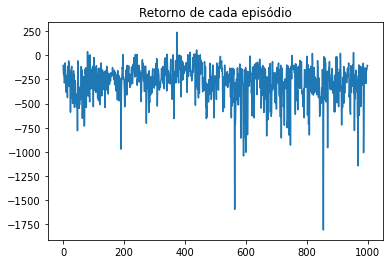

In [18]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.title("Retorno de cada episódio")
plt.show()

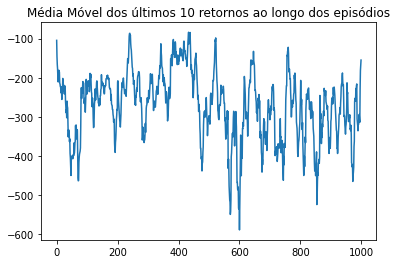

In [20]:
import matplotlib.pyplot as plt
plt.plot(avg_scores)
plt.title("Média Móvel dos últimos 10 retornos ao longo dos episódios")
plt.show()

In [6]:
#!pip install gym
import gym
env = gym.make('LunarLander-v2')
env.seed(42)
lr = 0.01
n_games = 1000

agent = Agent(gamma=0.95,
             epsilon=1.0,
             lr=lr,
             input_dims=env.observation_space.shape,
             n_actions=env.action_space.n,
             mem_size=10000,
             batch_size=128,
             epsilon_end=0.01,
             epsilon_dec=5e-3,
             fname='model_dqn_last.h5' )
scores = []
scores_max = []
scores_max_episodio = []
eps_history = []
avg_scores = []

for i in range(n_games):
    done = False
    score = 0
    observation = env.reset()
    
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        
        #env.render()
        
        score += reward
        scores_max_episodio.append(reward)
        agent.store_transition(observation, action, reward, observation_, done)
        observation = observation_
        agent.learn()
    scores_max.append(max(scores_max_episodio))
    
    agent.decay_eps()
    eps_history.append(agent.epsilon)
    scores.append(score)
    
    avg_score = np.mean(scores[-10:])
    avg_scores.append(avg_score)
    print('Episódio: ', i, ' Retorno %.2f' % score,
          'Retorno médio: %.2f' % avg_score, "Max Episódio: %.3f" % max(scores_max_episodio))
    scores_max_episodio = []
agent.save_model()
env.close()

C:\Users\zehlu\.conda\envs\car-dqn\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Episódio:  0  Retorno -350.22 Retorno médio: -350.22 Max Episódio: 1.173
Episódio:  1  Retorno -178.12 Retorno médio: -264.17 Max Episódio: 16.691
Episódio:  2  Retorno 32.89 Retorno médio: -165.15 Max Episódio: 91.924
Episódio:  3  Retorno -243.37 Retorno médio: -184.70 Max Episódio: 7.975
Episódio:  4  Retorno -266.91 Retorno médio: -201.14 Max Episódio: 7.670
Episódio:  5  Retorno -15.25 Retorno médio: -170.16 Max Episódio: 101.637
Episódio:  6  Retorno -114.40 Retorno médio: -162.20 Max Episódio: 7.573
Episódio:  7  Retorno -78.86 Retorno médio: -151.78 Max Episódio: 7.220
Episódio:  8  Retorno -133.54 Retorno médio: -149.75 Max Episódio: 26.284
Episódio:  9  Retorno -107.67 Retorno médio: -145.54 Max Episódio: 7.829
Episódio:  10  Retorno -189.96 Retorno médio: -129.52 Max Episódio: 96.577
Episódio:  11  Retorno -304.06 Retorno médio: -142.11 Max Episódio: 117.032
Episódio:  12  Retorno -240.63 Retorno médio: -169.46 Max Episódio: 81.619
Episódio:  13  Retorno -128.11 Retorno médi

KeyboardInterrupt: 

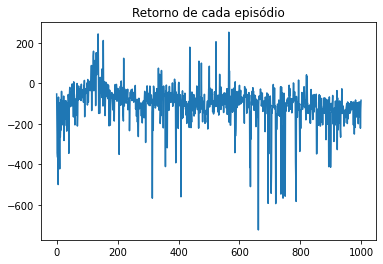

In [36]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.title("Retorno de cada episódio")
plt.show()

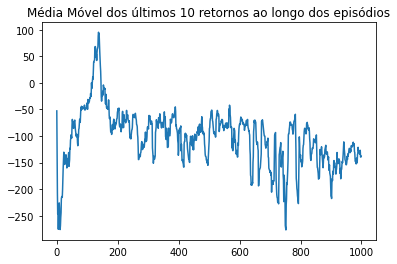

In [37]:
import matplotlib.pyplot as plt
plt.plot(avg_scores)
plt.title("Média Móvel dos últimos 10 retornos ao longo dos episódios")
plt.show()